## Librerías

In [ ]:
!pip install scikit-learn matplotlib seaborn wordcloud

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score
import joblib

In [ ]:
# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## Datos

In [ ]:
# Cargar datos
df = pd.read_csv('phishing_site_urls.csv')

print(f"📊 Dataset cargado: {df.shape[0]:,} URLs, {df.shape[1]} columnas")
print(f"\nColumnas: {df.columns.tolist()}")
print(f"\n📈 Distribución de clases:")
print(df['Label'].value_counts())
print(f"\nPorcentaje:")
print(df['Label'].value_counts(normalize=True) * 100)

# Primeras filas
print("\n--- Primeras URLs ---")
df.head()

📊 Dataset cargado: 549,346 URLs, 2 columnas

Columnas: ['URL', 'Label']

📈 Distribución de clases:
Label
good    392924
bad     156422
Name: count, dtype: int64

Porcentaje:
Label
good    71.525778
bad     28.474222
Name: proportion, dtype: float64

--- Primeras URLs ---


,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


## Exploración

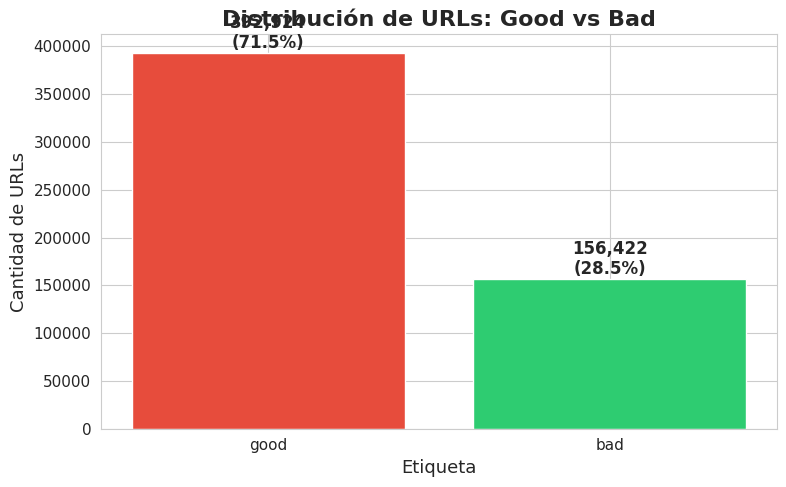


⚠️ Dataset desbalanceado detectado:
   Ratio bad/good: 0.4:1


In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
counts = df['Label'].value_counts()
colors = ['#e74c3c', '#2ecc71']  # Rojo para bad, verde para good
ax.bar(counts.index, counts.values, color=colors)
ax.set_title('Distribución de URLs: Good vs Bad', fontsize=16, fontweight='bold')
ax.set_ylabel('Cantidad de URLs', fontsize=13)
ax.set_xlabel('Etiqueta', fontsize=13)

# Agregar valores sobre las barras
for i, v in enumerate(counts.values):
    ax.text(i, v + 5000, f'{v:,}\n({v/len(df)*100:.1f}%)',
            ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Dataset desbalanceado detectado:")
print(f"   Ratio bad/good: {counts['bad'] / counts['good']:.1f}:1")


## Ejemplos

In [ ]:
print("🔍 EJEMPLOS DE URLs:\n")

print("--- URLs MALICIOSAS (bad) ---")
for url in df[df['Label'] == 'bad']['URL'].sample(5).tolist():
    print(f"   🚨 {url}")

print("\n--- URLs LEGÍTIMAS (good) ---")
for url in df[df['Label'] == 'good']['URL'].sample(5).tolist():
    print(f"   ✅ {url}")


🔍 EJEMPLOS DE URLs:

--- URLs MALICIOSAS (bad) ---
   🚨 www.arstaelteknik.com/6kpppb
   🚨 esxcc.com/js/index.htm?us.battle.net/login/en/?ref=albeykjus.battle.net/d3/en/index&app=com-d3
   🚨 bigislandhawaiihilorealestate.com/16h9p
   🚨 subys.com/mjguriv80
   🚨 24.98.162.74:35516/nymain/mr104348537876/index.php

--- URLs LEGÍTIMAS (good) ---
   ✅ web.uconn.edu/mcbstaff/graf/AvHm/LeechFarmsMain.htm
   ✅ mylife.com/jamesbishop2
   ✅ bergproperties.com/blog/radio-and-tv-talk-show-host-larry-elder-lists-his-four-bedroom-house-in-los-angeles-hollywood-hills-area-for-4-175m/
   ✅ facebook.com/FallenAsunder?sk=wall
   ✅ jgmf.blogspot.com/2010/10/gscbf7-steve-martin-and-john-mceuen.html


## Balancear

In [ ]:
from sklearn.utils import resample

# Separar por clase
df_good = df[df['Label'] == 'good']
df_bad = df[df['Label'] == 'bad']

print(f"📊 Dataset original:")
print(f"   Good: {len(df_good):,}")
print(f"   Bad: {len(df_bad):,}")

# Undersample: reducir 'bad' al tamaño de 'good' para balancear
df_good_sampled = resample(df_good, n_samples=len(df_bad), random_state=42)
df_balanced = pd.concat([df_good_sampled, df_bad])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n📊 Dataset balanceado:")
print(f"   Good: {(df_balanced['Label']=='good').sum():,}")
print(f"   Bad: {(df_balanced['Label']=='bad').sum():,}")
print(f"   Total: {len(df_balanced):,}")



📊 Dataset original:
   Good: 392,924
   Bad: 156,422

📊 Dataset balanceado:
   Good: 156,422
   Bad: 156,422
   Total: 312,844


## Tokenización

In [ ]:
def tokenize_url(url):
    """
    Tokeniza una URL separándola en componentes significativos

    Ejemplo:
    'https://github.com/user/repo' → ['https', 'github', 'com', 'user', 'repo']
    """
    # Reemplazar caracteres especiales por espacios
    tokens = url.replace('/', ' ').replace('.', ' ').replace('?', ' ') \
                .replace('=', ' ').replace('&', ' ').replace('-', ' ') \
                .replace('_', ' ').replace(':', ' ')

    # Dividir en tokens
    return tokens.split()

# Probar el tokenizer
print("🧪 PRUEBA DEL TOKENIZER:\n")
test_urls = [
    "https://www.google.com/search",
    "http://paypa1-verify.tk/login.php?id=123"
]

for url in test_urls:
    tokens = tokenize_url(url)
    print(f"URL: {url}")
    print(f"Tokens: {tokens}\n")


🧪 PRUEBA DEL TOKENIZER:

URL: https://www.google.com/search
Tokens: ['https', 'www', 'google', 'com', 'search']

URL: http://paypa1-verify.tk/login.php?id=123
Tokens: ['http', 'paypa1', 'verify', 'tk', 'login', 'php', 'id', '123']



## Vectorización TF-IDF

In [ ]:
print("🔄 Aplicando TF-IDF a las URLs...")

# Crear vectorizador TF-IDF con tokenizer personalizado
vectorizer = TfidfVectorizer(
    tokenizer=tokenize_url,
    max_features=5000,  # Top 5000 tokens más importantes
    lowercase=True
)

# Vectorizar URLs
X = vectorizer.fit_transform(df_balanced['URL'])
y = df_balanced['Label'].map({'good': 0, 'bad': 1})

print(f"✅ Matriz TF-IDF creada: {X.shape}")
print(f"   {X.shape[0]:,} URLs × {X.shape[1]} features (tokens)")
print(f"\n📝 Ejemplos de tokens más frecuentes:")
feature_names = vectorizer.get_feature_names_out()
print(f"   {list(feature_names[:20])}")


🔄 Aplicando TF-IDF a las URLs...
✅ Matriz TF-IDF creada: (312844, 5000)
   312,844 URLs × 5000 features (tokens)

📝 Ejemplos de tokens más frecuentes:
   ['%20secure%20login', '%21twysqajq', '%e2%80%93', "'", "'9d345009", "'paypal", "'services", "'update", "'us", "'www", '(album)', '(band)', '(disambiguation)', '(film)', '+', '0', "0'", '00', '000', '0001']


## Análisis de palabras importantes

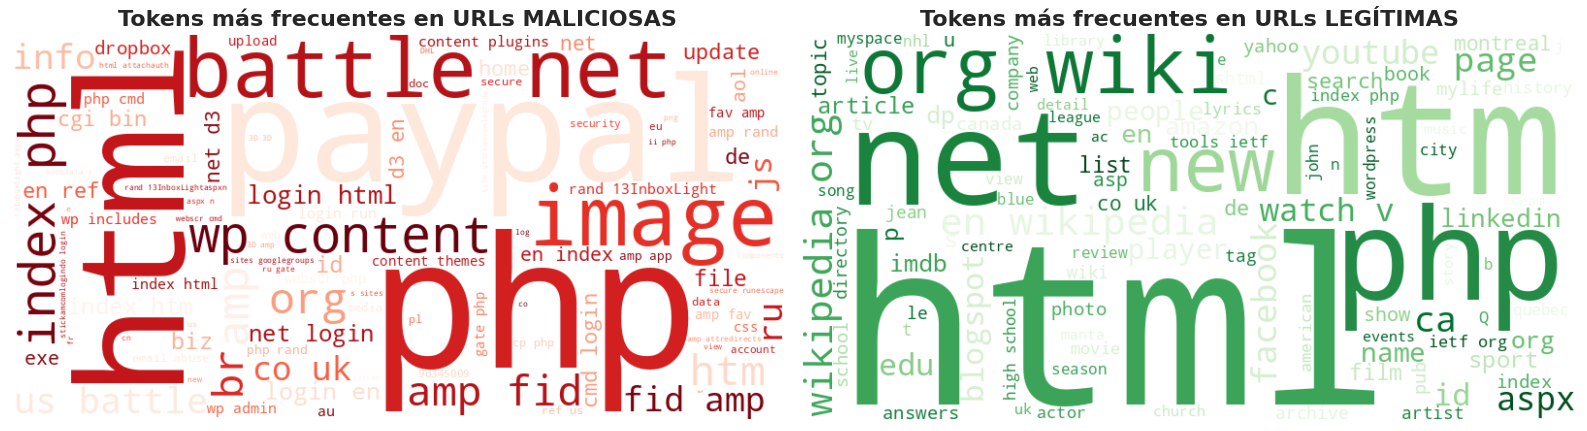

In [ ]:
# WordClouds para visualizar tokens más frecuentes

# URLs maliciosas
bad_urls = ' '.join(df_balanced[df_balanced['Label']=='bad']['URL'])
bad_tokens = ' '.join([' '.join(tokenize_url(url)) for url in df_balanced[df_balanced['Label']=='bad']['URL'].sample(1000)])

# URLs legítimas
good_tokens = ' '.join([' '.join(tokenize_url(url)) for url in df_balanced[df_balanced['Label']=='good']['URL'].sample(1000)])

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# WordCloud de URLs maliciosas
wc_bad = WordCloud(width=800, height=400, background_color='white',
                    colormap='Reds', max_words=100).generate(bad_tokens)
axes[0].imshow(wc_bad, interpolation='bilinear')
axes[0].set_title('Tokens más frecuentes en URLs MALICIOSAS', fontsize=16, fontweight='bold')
axes[0].axis('off')

# WordCloud de URLs legítimas
wc_good = WordCloud(width=800, height=400, background_color='white',
                     colormap='Greens', max_words=100).generate(good_tokens)
axes[1].imshow(wc_good, interpolation='bilinear')
axes[1].set_title('Tokens más frecuentes en URLs LEGÍTIMAS', fontsize=16, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📦 División de datos (80/20):")
print(f"   Entrenamiento: {X_train.shape[0]:,} URLs")
print(f"   Prueba: {X_test.shape[0]:,} URLs")
print(f"\n   Distribución en train:")
print(f"      Good: {(y_train==0).sum():,}")
print(f"      Bad: {(y_train==1).sum():,}")
print(f"\n   Distribución en test:")
print(f"      Good: {(y_test==0).sum():,}")
print(f"      Bad: {(y_test==1).sum():,}")


📦 División de datos (80/20):
   Entrenamiento: 250,275 URLs
   Prueba: 62,569 URLs

   Distribución en train:
      Good: 125,137
      Bad: 125,138

   Distribución en test:
      Good: 31,285
      Bad: 31,284


### Entrenamiento

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=20, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=8, random_state=42),
    'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42)
}
results = {}
for name, model in models.items():
    print(f'Entrenando {name}...')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, 'predict_proba') else None
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    results[name] = {'model': model, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'auc': auc}
    print(f"   Acc: {acc:.4f}, Prec: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")



Entrenando Logistic Regression...
   Acc: 0.9158, Prec: 0.9507, Recall: 0.8772, F1: 0.9124, AUC: 0.9799
Entrenando Random Forest...
   Acc: 0.8299, Prec: 0.9080, Recall: 0.7341, F1: 0.8118, AUC: 0.9310
Entrenando Decision Tree...
   Acc: 0.8292, Prec: 0.8086, Recall: 0.8625, F1: 0.8347, AUC: 0.9147
Entrenando Gradient Boosting...
   Acc: 0.8487, Prec: 0.9070, Recall: 0.7771, F1: 0.8370, AUC: 0.9426
Entrenando AdaBoost...
   Acc: 0.7595, Prec: 0.8116, Recall: 0.6758, F1: 0.7375, AUC: 0.8110


### Comparación

                     accuracy precision    recall        f1       auc
Logistic Regression  0.915821  0.950667  0.877158  0.912434   0.97987
Gradient Boosting    0.848711  0.907022  0.777075  0.837035  0.942582
Decision Tree        0.829165  0.808613  0.862454  0.834666  0.914702
Random Forest        0.829852  0.907962  0.734113  0.811835  0.930959
AdaBoost             0.759498  0.811631  0.675841  0.737538  0.810993


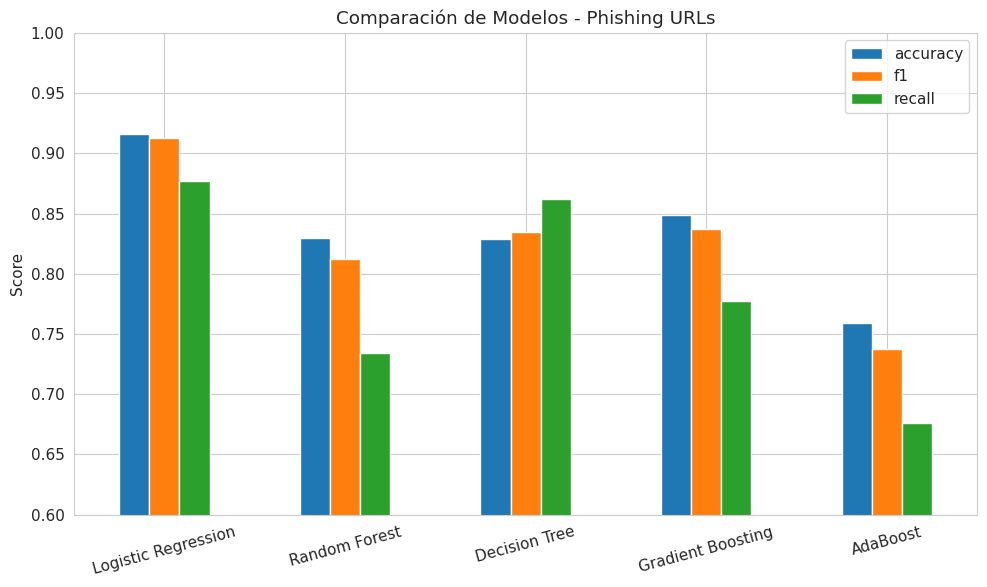

In [ ]:
df_results = pd.DataFrame(results).T[['accuracy','precision','recall','f1','auc']]
print(df_results.sort_values('f1', ascending=False).round(4))

# Gráfica
fig, ax = plt.subplots(figsize=(10,6))
df_results[['accuracy','f1','recall']].plot(kind='bar', ax=ax)
plt.title('Comparación de Modelos - Phishing URLs')
plt.ylabel('Score')
plt.ylim(0.6, 1.0)
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


## Reporte y matriz de confusión del mejor modelo


🏆 Mejor modelo: Logistic Regression
              precision    recall  f1-score   support

    Legítima       0.81      0.92      0.86     31285
    Phishing       0.91      0.78      0.84     31284

    accuracy                           0.85     62569
   macro avg       0.86      0.85      0.85     62569
weighted avg       0.86      0.85      0.85     62569



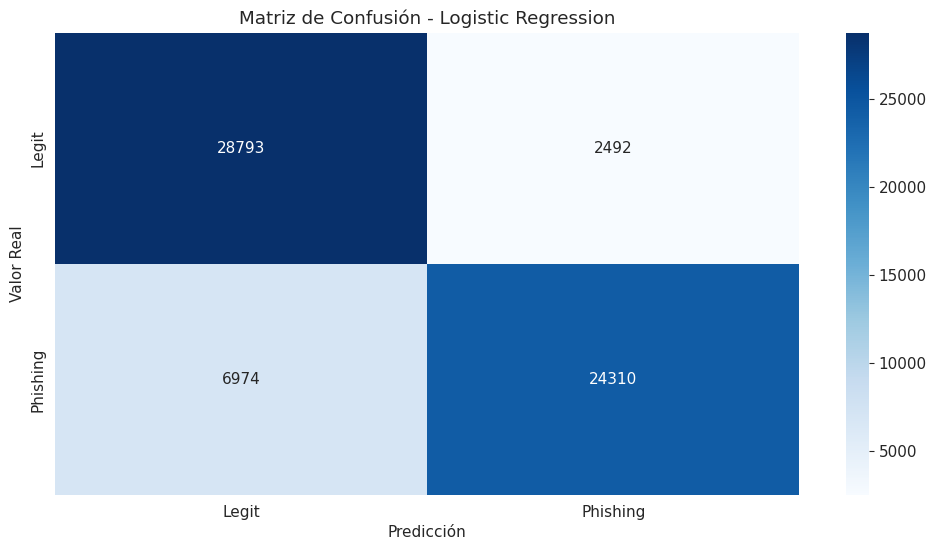

In [53]:
best_name = df_results['f1'].idxmax()
best = results[best_name]
print(f"\n🏆 Mejor modelo: {best_name}")
y_pred_best = model.predict(X_test)
print(classification_report(y_test, y_pred_best, target_names=['Legítima','Phishing']))

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit','Phishing'], yticklabels=['Legit','Phishing'])
plt.title(f'Matriz de Confusión - {best_name}')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()


## Guardar modelo y vectorizer

In [ ]:
import joblib
joblib.dump(best['model'], f'phishing_url_{best_name.replace(" ", "_").lower()}.pkl')
joblib.dump(vectorizer, 'url_tfidf_vectorizer.pkl')
print(f"✅ Guardado modelo y vectorizador del mejor clasificador: {best_name}")


✅ Guardado modelo y vectorizador del mejor clasificador: Logistic Regression


## Predicciones

In [76]:
def predict_url(url, model, vectorizer):
    """
    Predice si una URL es phishing o legítima
    """
    vec = vectorizer.transform([url])
    pred = model.predict(vec)[0]
    proba = model.predict_proba(vec)[0]


    if pred == 0:
        label = "✅ LEGÍTIMA"
        confidence = proba[0] * 100
    else:  # pred==1 → PHISHING
        label = "🚨 PHISHING"
        confidence = proba[1] * 100

    return label, confidence

test_urls = [
    "mylife.com/high-schools/qc/montreal/ecole-sec-georges-vanier/",
    "www.thinks.com/puzzles/dudeney/dudeney.htm",
    "pkbsurf.com.br/aolfile010/570d3e49c6bc9b64a84c1d02093ad580/",
    "http://www.allegro.xaa.pl/enter_login.html?session=OGY1YgQGXQALBwcxzvcxNYWgFVVgMPBgANAAcEAwMHDg1cUlEBAFNbDABQAwEHUlvcbcvxcgbcANzA5OA\%3D\%3D&amp;global_login_hash=1f0f47e7fcvxvvc8fb48f851c41eafvdgdg33a7&amp;session_login_hash=e4baf33efvdsfdsg6422224f66b652028fvcxfvde726&amp;url=N2NjOAwWQBYNTExZCAzxzdfvzgfhfgVgAAVxEMQElzBgFZEAdHSXMGAVkQB0dIRwsTFxYHRxZYDRBdIg1GCvdgdgcxzcszdfbgFRWZGI0Zg\%3D\%3D&amp;cod=OGZkcsVlNmcsk&amp;version=A"
]

for url in test_urls:
    label, conf = predict_url(url, best['model'], vectorizer)
    print(f"{label} ({conf:.1f}%): {url}")



✅ LEGÍTIMA (99.8%): mylife.com/high-schools/qc/montreal/ecole-sec-georges-vanier/
✅ LEGÍTIMA (90.9%): www.thinks.com/puzzles/dudeney/dudeney.htm
🚨 PHISHING (99.8%): pkbsurf.com.br/aolfile010/570d3e49c6bc9b64a84c1d02093ad580/
🚨 PHISHING (100.0%): http://www.allegro.xaa.pl/enter_login.html?session=OGY1YgQGXQALBwcxzvcxNYWgFVVgMPBgANAAcEAwMHDg1cUlEBAFNbDABQAwEHUlvcbcvxcgbcANzA5OA\%3D\%3D&amp;global_login_hash=1f0f47e7fcvxvvc8fb48f851c41eafvdgdg33a7&amp;session_login_hash=e4baf33efvdsfdsg6422224f66b652028fvcxfvde726&amp;url=N2NjOAwWQBYNTExZCAzxzdfvzgfhfgVgAAVxEMQElzBgFZEAdHSXMGAVkQB0dIRwsTFxYHRxZYDRBdIg1GCvdgdgcxzcszdfbgFRWZGI0Zg\%3D\%3D&amp;cod=OGZkcsVlNmcsk&amp;version=A
